*Luis Antonio Ortega Andrés       
Antonio Coín Castro*

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm, cauchy, t, expon
import scipy.integrate as integrate
import seaborn as sns
from scipy import clip

seed = 42
np.random.seed(seed)

# Algoritmo de aceptación y rechazo (A/R)

## Ejercicio 1

Supongamos la función

$$
f(x)=\sin(2\pi x)^5−2\sin\left(3\cos\left(\frac{x}{\pi}\right)^2\right)^3 +3
$$

y el intervalo $(a,b)=(0,10)$. Estimar el área delimitada por la función $f(x)$  en el intervalo $(a,b)$. Evaluar (gráficamente) la precisión (incertidumbre) de la estimación.

*Nota*: la función original se ha modificado porque no coincidía con la gráfica que se muestra en los apuntes.

In [2]:
def plot_f(f, x):
    plt.title("Gráfica de f")
    plt.plot(x,f(x))
    plt.show()

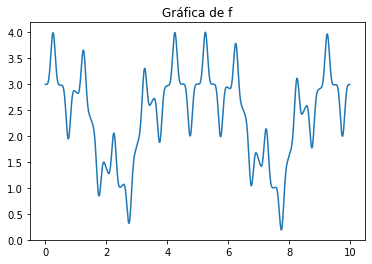

In [3]:
# Mostramos la función
f = lambda x: np.sin(2*np.pi*x)**5 -2*np.sin(3*np.cos(x/np.pi)**2)**3 + 3
x = np.arange(0, 10, 0.01)
plot_f(f,x)

Implementamos el algoritmo de aceptación/rechazo por Monte Carlo.

In [4]:
def mc_ar(f, xlims, ylims, samples = 50000, plot = False, verbose = False):
    x = uniform.rvs(xlims[0], xlims[1] - xlims[0], samples)
    y = uniform.rvs(ylims[0], ylims[1] - ylims[0], samples)
    good = y <= f(x)
    wrong = np.logical_not(good)
    
    if plot:
        plt.scatter(x[good], y[good], s=1, color="red")
        plt.scatter(x[wrong], y[wrong], s=1, color="blue")
        plt.title(f"Aciertos (rojo) y fallos (azul), nsamples={samples}")
        plt.show()
        
    area_rect = (xlims[1] - xlims[0])*(ylims[1]- ylims[0])
    mean = np.mean(good)
    area = area_rect*mean
    
    if verbose:
        print("Resultado integración:", integrate.quad(f, *xlims, limit=100)[0], 
              "\nEstimación A/R:", area)
    return area

Probamos este método de integración con nuestra función $f$ en $[0,10]\times[0,5]$, y vemos que conseguimos una buena estimación.

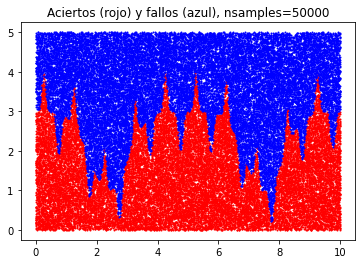

Resultado integración: 23.987186930717478 
Estimación A/R: 24.005000000000003


In [5]:
res_ar = mc_ar(f, (0,10), (0,5), samples=50000, plot=True, verbose = True)

Podemos tomar la función que se daba en los apuntes, que toma valores negativos y calcular su area restando su parte positiva a su parte negativa.

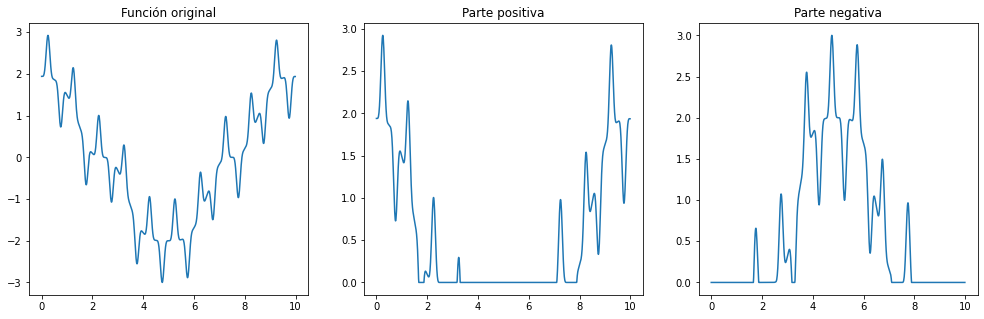

In [6]:
f1 = lambda x: np.sin(2*np.pi*x)**5 -2*np.cos(3*np.cos(x/np.pi)**2)**3
x = np.arange(0, 10, 0.01)
f1_max = lambda x: f1(x).clip(min=0)
f1_min = lambda x: np.abs(f1(x).clip(max=0))
fig, axes = plt.subplots(1,3, figsize=(17,5))
axes[0].plot(x, f1(x))
axes[1].plot(x, f1_max(x))
axes[2].plot(x, f1_min(x))
axes[0].set_title("Función original")
axes[1].set_title("Parte positiva")
axes[2].set_title("Parte negativa")
plt.show()

Parte positiva:


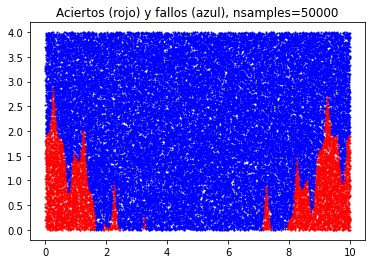

Resultado integración: 5.818992213469915 
Estimación A/R: 5.7952

Parte negativa:


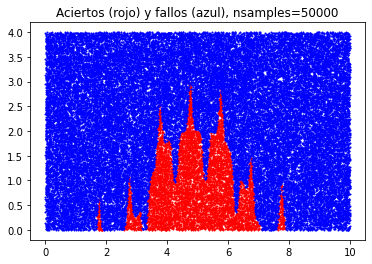

Resultado integración: 6.435577896024718 
Estimación A/R: 6.3288

Resultado integración total: -0.616585682554799 
Estimación total A/R: -0.5335999999999999


In [7]:
print("Parte positiva:")
area_pos = mc_ar(f1_max, (0,10), (0,4), samples=50000, plot=True, verbose = True)
print("\nParte negativa:")
area_neg = mc_ar(f1_min, (0,10), (0,4), samples=50000, plot=True, verbose = True)

print("\nResultado integración total:", integrate.quad(f1, 0,10)[0], 
              "\nEstimación total A/R:", area_pos - area_neg)

Para evaluar gráficamente la precisión del método, repetimos el experimento 1000 veces, primero utilizando 1000 lanzamientos en el método A/R, y después utilizando 10000. Pintamos la densidad y la distribución empírica obtenida, y observamos que se asemeja a una normal.

In [8]:
n1, n2 = 1000, 10000
nrep = 1000
res1 = np.array([mc_ar(f, (0,10), (0, 5), n1) for _ in range(nrep)])
res2 = np.array([mc_ar(f, (0,10), (0, 5), n2) for _ in range(nrep)])

In [9]:
# Función para dibujar las gráficas
def plot_kde_ecdf(x1, x2, labels, value):
    _, axes = plt.subplots(1, 2, figsize=(15,5))
    axes[0].set_title(f"Densidad en {len(x1)} repeticiones con N lanzamientos")
    sns.kdeplot(x1, ax = axes[0], fill = True, label=labels[0])
    sns.kdeplot(x2, ax = axes[0], fill = True, label=labels[1])
    ylims = axes[0].get_ylim()
    axes[0].vlines(value, *ylims, color = "red")
    axes[0].set_ylim(*ylims)
    axes[0].set_xlabel("Área estimada")
    axes[1].set_title("Distribución empírica")
    sns.ecdfplot(x1, ax = axes[1], label=labels[0])
    sns.ecdfplot(x2, ax = axes[1], label=labels[1])
    axes[1].set_xlabel("Área estimada")
    axes[0].legend()
    axes[1].legend()

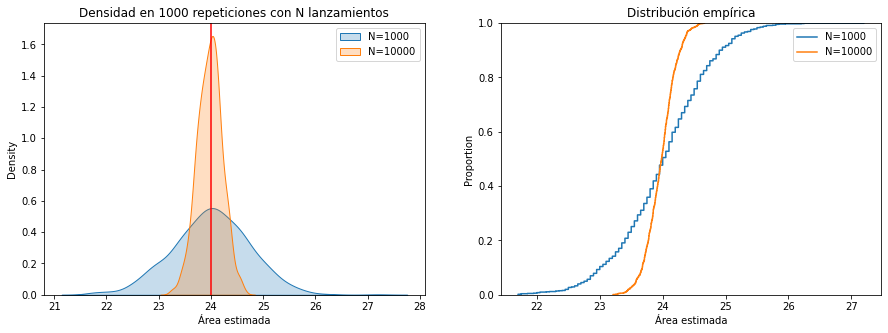

In [10]:
plot_kde_ecdf(res1, res2, [f"N={n1}", f"N={n2}"], res_ar)

# Algoritmo basado en medias

## Ejercicio 2

Calcula la integral
$$
\int_0^1 (1-x^2)^{1/2}\,dx = \frac{\pi}{4}
$$

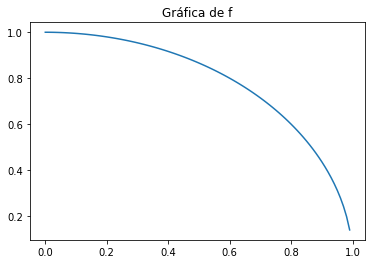

In [11]:
# Mostramos la función
h = lambda x: (1-x**2)**(0.5)
x=np.arange(0,1,0.01)
plot_f(h,x)

Implementamos el algoritmo de Monte Carlo basado en medias.

In [12]:
def mc_means(h, samples = 10000):
    x = uniform.rvs(0, 1, samples)
    return np.mean(h(x))

In [13]:
res_means = mc_means(h)
print("Valor obtenido por MC: ", res_means, "\nValor real: ", np.pi/4)

Valor obtenido por MC:  0.785247274292193 
Valor real:  0.7853981633974483


Comparamos la distribución de 5000 repeticiones del algoritmo basado en medias y del algoritmo de A/R, ambos con 10000 lanzamientos.

In [14]:
nrep=5000
n=10000
res1 = np.array([mc_ar(h, (0,1), (0, 2), n) for _ in range(nrep)])
res2 = np.array([mc_means(h, n) for _ in range(nrep)])

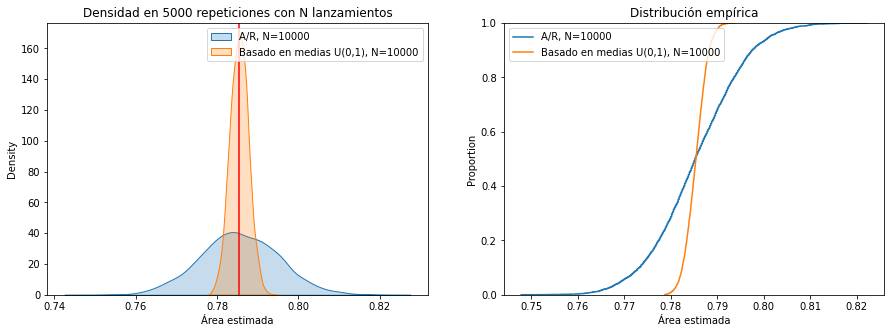

In [15]:
plot_kde_ecdf(res1, res2, ["A/R, N=10000", "Basado en medias U(0,1), N=10000"], np.pi/4)

Realizamos ahora varias repeticiones de la estimación basada en medias, aumentando paulatinamente el número de puntos desde 1 hasta 50000, proporcionando también un intervalo de confianza al 99.5% en cada caso. A la hora de dibujarlo comenzamos desde 50 puntos para visualizarlo mejor, ya que con pocos puntos la varianza es muy grande.

In [16]:
def mc_means_cummulative(h, n, alpha = 0.005, offset=0):
    x = uniform.rvs(0,1, size=n + offset)
    y = h(x)
    
    # Establecemos la sucesión de puntos
    size = np.arange(start = 1, stop = len(x)+1, step = 1)

    # Calculamos la media de h progresivamente en todos los puntos 
    media = np.cumsum(y) / size

    # Calculamos el valor z_alpha para el intervalo de confianza
    z_alpha = norm.ppf(1-alpha/2)

    # Calculamos la varianza
    s2 = (y - media) * (y - media)
    s2[1:] = np.cumsum(s2)[1:]/size[0:-1]
    
    # Calculamos el intervalo de confianza
    ic = z_alpha*np.sqrt(s2)/np.sqrt(size)

    return media[offset:], ic[offset:]

In [17]:
def cum_sample_plot(f, n_samples, real_value = None, offset = 0, ax = None, print_ic = False, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    media, ic = mc_means_cummulative(f, n_samples, alpha=0.005, offset=offset)
    size = np.arange(start = 1, stop = len(media)+1, step = 1)
    sns.lineplot(x = size, y = media, lw=.3, ax=ax)

    if real_value is not None:
        ax.plot([1, len(media)], 2*[real_value], '--', color='k', lw=.75)
    ax.set_xlabel("Sample size")
    ax.set_ylabel(r"Estimated integral value")
    ax.set_title(title)

    if print_ic:
        # Dibujamos los intervalos de confianza de forma continua
        ax.fill_between(size, media-ic, media+ic, color='b', alpha=.1)

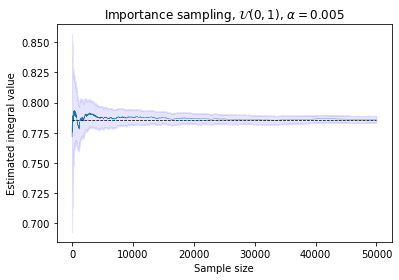

In [35]:
cum_sample_plot(h, 50000, np.pi/4, 50, print_ic = True, 
                title = r"Importance sampling, $\mathcal{U}(0,1)$, $\alpha=0.005$")
plt.show()

Ahora realizamos 100 ejecuciones independientes del experimento desde 1 hasta 30000 puntos, y mostramos los resultados.

Calculando las 100 iteraciones del experimento: [====================] 100%

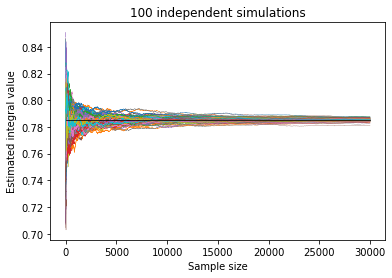

In [19]:
fig, ax = plt.subplots()
ax.set_title("100 independent simulations")
ax.set_xlabel("Sample size")
ax.set_ylabel(r"Estimated integral value, $\pi/4$")

for i in range(100):
    # Display waiting bar
    sys.stdout.write('\r')
    sys.stdout.write("Calculando las 100 iteraciones del experimento: [%-20s] %d%%" % ('='*((i+5)//5), i+1))
    sys.stdout.flush()
    
    cum_sample_plot(h, 30000, offset = 50, ax = ax, print_ic = False, title ="100 independent simulations")

ax.plot([0, 30000], 2*[np.pi/4], color='k', lw=.75)
plt.show()

# Muestreo por importancia
## Ejercicio 3

Estimar la integral
$$
\int_0^1 \cos(50x)+\sin(20x)\, dx
$$

por Monte Carlo. Analice la convergencia de la estimación en función del tamaño de la muestra y proporcione un intervalo de confianza.

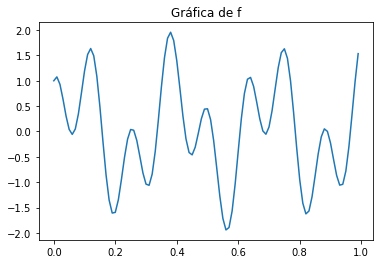

In [20]:
f3=lambda x: np.cos(50*x)+np.sin(20*x)
x=np.arange(0, 1, 0.01)
plot_f(f3,x)

Aplicamos el método de *importance sampling* como antes, proporcionando intervalos de confianza.

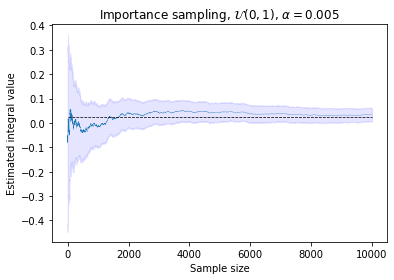

In [21]:
# Calculamos el área real
area=(1/50) *(5 * np.sin(10)**2 + np.sin(50))

cum_sample_plot(f3, 10000, area, 50, print_ic = True, 
                title = r"Importance sampling, $\mathcal{U}(0,1)$, $\alpha=0.005$")
plt.show()

## Ejercicio 4

Estimar el valor de la integral
$$
\int_0^{10}e^{-2|x-5|}\, dx.
$$

Definimos una generalización del método de *importance sampling* donde se puede pasar cualquier función de densidad que se quiera utilizar como argumento a la función. 

In [22]:
def importance_sampling(f, generative_f, density_f, samples):
    x = generative_f(samples)
    y = f(x)/density_f(x)
    return np.mean(y)

def importance_sampling_cum(f, generative, density, samples=10000, alpha = 0.005, offset=0):    
    x = generative(samples+offset)
    y = f(x)/[density(a) for a in x]

    # Establecemos la sucesión de puntos
    size = np.arange(start = 1, stop = len(x)+1, step = 1)

    # Calculamos la media de h progresivamente en todos los puntos 
    media = np.cumsum(y) / size

    # Calculamos el valor z_alpha para el intervalo de confianza
    z_alpha = norm.ppf(1-alpha/2)

    # Calculamos la varianza
    s2 = (y - media) * (y - media)
    s2[1:] = np.cumsum(s2)[1:]/size[0:-1]
    
    # Calculamos el intervalo de confianza
    ic = z_alpha*np.sqrt(s2)/np.sqrt(size)

    return media[offset:], ic[offset:]

In [23]:
def cum_importance_plot(f, g, d, n_samples, real_value = None, offset = 0, 
                        ax = None, print_ic = False, title =None, label=None, color=None):    
    if ax is None:
        fig, ax = plt.subplots()
    
    media, ic = importance_sampling_cum(f, g, d, n_samples, alpha=0.005, offset=offset)

    size = np.arange(start = 1, stop = len(media)+1, step = 1)
    sns.lineplot(x=size, y = media, lw=.3, ax=ax, label = label, color=color)
    
    if real_value is not None:
        ax.plot([1, len(media)], 2*[real_value], '--', color='k', lw=1)
        
    ax.set_xlabel("Sample size")
    ax.set_ylabel(r"Estimated integral value")
    ax.set_title(title)

    if print_ic:
        # Dibujamos los intervalos de confianza de forma continua
        ax.fill_between(size, media-ic, media+ic, color='b', alpha=.1)

Pintamos la función que buscamos integrar.

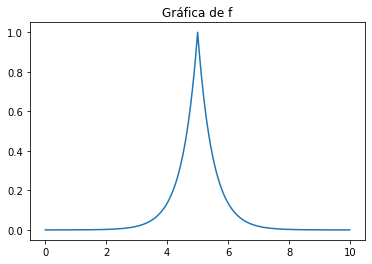

In [24]:
f4 = lambda x: np.exp(-2*np.abs(x - 5))
plot_f(f4, np.arange(0, 10, 0.01))

Pintamos por un lado la función junto con las densidades que se van a utilizar en el método de integración, y por otro la convergencia que muestra el método con cada una de estas densidades.

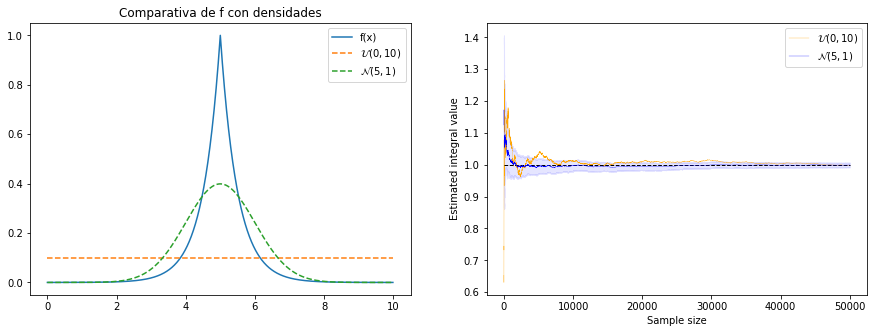

In [34]:
_, axes = plt.subplots(1, 2, figsize=(15,5))

# Axes
x = np.arange(0, 10, 0.01)
axes[0].set_title("Comparativa de f con densidades")
axes[0].plot(x,f4(x), label = "f(x)")
axes[0].plot([0,10], 2*[1/10], '--', label = r"$\mathcal{U}(0,10)$")
axes[0].plot(x, norm.pdf(x, 5, 1), '--', label=r'$\mathcal{N}(5,1)$')
axes[0].legend()
axes[1].set_title("Repeticiones de los experimentos con aumento paulatino del número de puntos")

samples = 50000
offset = 50

generative1 = lambda x: uniform.rvs(0, 10, size=x)
generative2 = lambda x: norm.rvs(5, 1, size=x)
 
# First experiment
cum_importance_plot(f4, generative1, lambda x: 1/10, samples, 1, 
                    offset, axes[1], False, label = r'$\mathcal{U}(0, 10)$', color = 'orange')

# Second experiment
cum_importance_plot(f4, generative2, lambda x: norm.pdf(x,5,1), samples, None, 
                    offset, axes[1], True, label = r'$\mathcal{N}(5,1)$', color = 'b')

plt.show()

## Ejercicio 5

Suponed que desconocemos la c.d.f. de una v.a $\mathcal N(0,1)$. Aproximar por Monte Carlo el área bajo la p.d.f en el intervalo $[−50,50]$. Esta cantidad será extremadamente cercana a 1, "de hecho" es 1. 

Utilizaremos una serie de funciones de muestreo de importancia para ilustrar el método:

- una densidad uniforme $\mathcal U(−50,50)$,
- una densidad Cauchy truncada en el intervalo $[−50,50]$, y 
- una distribución $t$ de 30 grados de libertad truncada en el mismo intervalo.

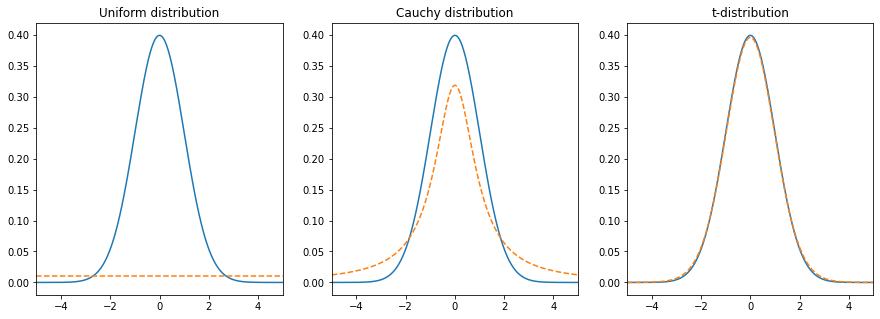

In [26]:
x = np.arange(-50, 50, 0.01)
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].set_title("Uniform distribution")
axes[0].plot(x, norm.pdf(x))
axes[0].plot(x, uniform.pdf(x, -50, 100), '--')
axes[0].set_xlim(-5, 5)

axes[1].set_title("Cauchy distribution")
axes[1].plot(x, norm.pdf(x))
axes[1].plot(x, cauchy.pdf(x), '--')
axes[1].set_xlim(-5, 5)

axes[2].set_title("t-distribution")
axes[2].plot(x, norm.pdf(x))
axes[2].plot(x, t.pdf(x, 30), '--')
axes[2].set_xlim(-5, 5)

plt.show()

La figura muestra las tres funciones de muestreo como una curva punteada junto a la curva normal. Ahora vamos a representar el histograma realizado con 5.000 estimaciones de Monte Carlo (utilizando un tamaño de muestra $n = 1000$) del área bajo la curva normal. 

En primer lugar, definimos una función `truncate` que nos devuelve la p.d.f, c.d.f y p.p.f de una distribución cualquiera truncada al intervalo $[a,b]$, donde $-\infty \leq a < b \leq \infty$. La densidad de la distribución truncada se define como

$$
f(x | a \leq X \leq b) = \frac{f(x) I_{\{a \leq x \leq b\}}}{F(b)-F(a)}, \quad x \in \mathcal X.
$$

Se puede comprobar que efectivamente es una densidad, ya que integra 1. Integrando esta expresión entre $-\infty$ y $x$ obtenemos la función de distribución truncada:

$$
F(x| a \leq X \leq b) = \begin{cases} 
\frac{F(x)-F(a)}{F(b)-F(a)}, & a \leq x \leq b,\\
0, & x \leq a,\\
1, & x \geq b.
\end{cases}
$$

Por último, invirtiendo esta función llegamos a la expresión de la función de percentil truncada:

$$
F^{-1}(q| a \leq F^{-1}(q) \leq b) = F^{-1}((F(b)-F(a))q + F(a)), \quad q \in [0, 1].
$$

In [27]:
def truncate(f, F, F_inv, a, b):
    F_a = 0.0 if a==-np.inf else F(a)
    F_b = 1.0 if b==np.inf else F(b)
    Phi = F_b - F_a
    
    pdf = lambda X: (f(X) * ((a <= X) & (X <= b))) / Phi
    cdf = lambda X: np.clip((F(X)-F_a) / Phi, 0, 1)
    ppf = lambda X: F_inv(X * Phi + F(a))
    return pdf, cdf, ppf

Para obtener una muestra de la distribución truncada empleamos el método de la inversa de la función de distribución.

In [28]:
def rvs(F_inv, n):
    x=uniform.rvs(size=n)
    return F_inv(x)

Finalmente definimos las distribuciones truncadas como queríamos y representamos los histogramas.

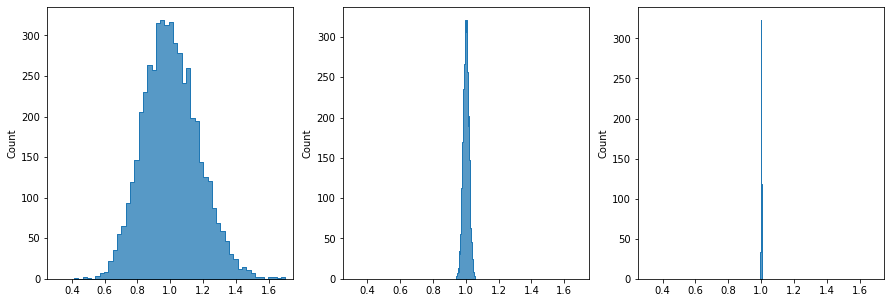

In [29]:
samples = 1000
n_rep = 5000
df = 30

pdf_cauchy, cdf_cauchy, ppf_cauchy = truncate(cauchy.pdf, cauchy.cdf, cauchy.ppf, -50, 50)
pdf_t, cdf_t, ppf_t = truncate(lambda x: t.pdf(x, df), lambda x: t.cdf(x, df), lambda q: t.ppf(q, df), -50, 50)

g1 = lambda x: uniform.rvs(-50, 100, size =  x)
g2 = lambda x: rvs(ppf_cauchy, x)
g3 = lambda x: rvs(ppf_t, x)

d1 = lambda x: uniform.pdf(x, -50, 100)
d2 = lambda x: pdf_cauchy(x)
d3 = lambda x: pdf_t(x)

fig, axes = plt.subplots(1,3, figsize=(15,5))
res1 = [importance_sampling(norm.pdf, g1, d1, samples) for _ in range(n_rep)]
res2 = [importance_sampling(norm.pdf, g2, d2, samples) for _ in range(n_rep)]
res3 = [importance_sampling(norm.pdf, g3, d3, samples) for _ in range(n_rep)]

sns.histplot(res1, ax=axes[0], element="step")
sns.histplot(res2, ax=axes[1], element="step")
sns.histplot(res3, ax=axes[2], element="step")

axes[0].set_xlim(0.25, 1.75)
axes[1].set_xlim(0.25, 1.75)
axes[2].set_xlim(0.25, 1.75)

plt.show()

## Ejercicio 6

Un error común del muestreo por importancia consiste en despreciar la contribución de las colas de las distribuciones. Aunque la función de importancia $f(x)$ pueda tener aproximadamente la misma forma que $g(x)$, surgirán dificultades serias si $f(x)$ disminuye más rápidamente que $g(x)$ en las colas.

Muestra el histograma de 5000 estimaciones de Monte Carlo del área entre -50 y 50 de la densidad de una distribución de Cauchy (truncada en -50 y 50 y renormalizada de modo que el área exacta sea 1) cuando se utiliza como función de importancia la densidad normal estándar (que, obviamente, decrece en las colas mucho más rápidamente que la distribución de Cauchy).

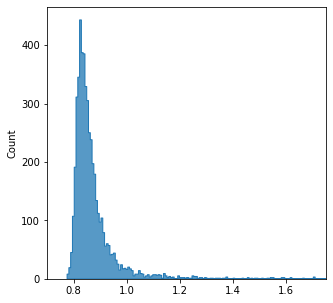

Número de simulaciones cuyo estimador excede 1.5: 50
Estimaciones que exceden 1.5:
 [ 1.88356649  1.95243124  3.16467425  4.3297098   1.5815884   1.5925294
  1.97116324  2.64965065  2.10630472  1.533226    5.04453167  5.5789272
  1.70776648  1.61766741  2.33602692  1.54493104  1.51198173  2.06088722
  1.5910326   2.11789607  2.54574183  1.87467985  1.70826021  1.54672397
  2.30160389  1.81961345  2.40215175  3.43522034  2.89483372  1.61672972
  2.41368909  2.07400245  4.48792774  1.98981206  7.4314828   1.55267976
  2.38979318 17.26732854  2.28475695  2.03009665  1.58616047  1.70575087
  2.03877394 21.23624673  1.55054847  1.66276902  2.17646612 17.6138652
  1.53516149  1.98774701]
Valor más alto estimado: 21.236246731643796


In [30]:
samples = 1000
n_rep = 5000

pdf_cauchy, _, _ = truncate(cauchy.pdf, cauchy.cdf, cauchy.ppf, -50, 50)
g = lambda x: norm.rvs(size=x)
d = lambda x: norm.pdf(x)

fig, ax = plt.subplots(1,1, figsize=(5,5))
res = np.array([importance_sampling(pdf_cauchy, g, d, samples) for _ in range(n_rep)])

sns.histplot(res, ax=ax, element="step")
ax.set_xlim(0.7, 1.75)
plt.show()

bad_estimates = res[res > 1.5]
print("Número de simulaciones cuyo estimador excede 1.5:", len(bad_estimates))
print("Estimaciones que exceden 1.5:\n", bad_estimates)
print("Valor más alto estimado:", max(bad_estimates))

Nótese que alrededor de 60 de las 5000 estimaciones de Monte Carlo para el área de la función de Cauchy truncada fueron mayores que 1.5, siendo algunas de las estimaciones muy superiores a ese valor.

## Ejercicio 7

Suponga la v.a $X\sim \mathcal N(0,1)$. Estime mediente métodos de Monte Carlo la $P(X>4.5)$, suponiendo que desconocemos su c.d.f. Es decir, estime el valor de la integral

$$
I=\frac{1}{2\sqrt\pi} \int_{4.5}^\infty e^{-x^2/2}\, dx.
$$

### Solución 1

Podemos definir la función $g(x)$ en $(-\infty, \infty)$ dada por

$$
g(x)=\begin{cases}
\frac{1}{2\sqrt\pi} e^{-x^2/2}, & x \geq 4.5,\\
0, & \text{en otro caso}.
\end{cases}
$$

y estimamos la integral $I=\int_{-\infty}^\infty g(x)\, dx$ utilizando como función de importancia la densidad de una $\mathcal N(0,1)$.

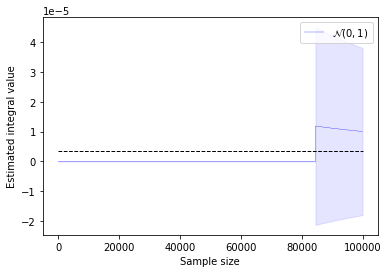

In [38]:
samples = 100000
offset = 50

d_norm = lambda x: norm.pdf(x)
g_norm = lambda x: norm.rvs(size=x)
f_norm = lambda X: norm.pdf(X) * (X >= 4.5)

cum_importance_plot(f_norm, g_norm, d_norm, samples, integrate.quad(f_norm, 4.5, np.inf)[0], 
                    offset, None, True, label = r'$\mathcal{N}(0, 1)$', color='b')

El problema con esta estrategia es que dado que la $P(X>4.5)$ es $\sim 10^{−6}$, estamos interesados en eventos muy raros. La probabilidad de obtener una muestra mayor de 4.5 (esto es la probabilidad de $g(X)\neq 0$) requeriría una gran cantidad de iteraciones para obtener una respuesta estable.

### Solución 2

Si utilizamos otra función de importancia, podemos mejorar nuestra precisión y reducir el número de iteraciones en varios órdenes de magnitud. Por ejemplo, si consideramos una distribución con soporte restringido al intervalo $[4.5,\infty)$, la variación adicional e innecesaria del estimador de Monte Carlo debido a la presencia de ceros cuando $x<4.5$ desaparece.

Una elección natural es elegir como función $f(x)$ la distribución exponencial $Exp(1)$ truncada en el intervalo $[4.5,\infty)$, es decir:

$$
f(x)= \frac{e^{-x}}{\int_{4.5}^\infty e^{-x}\, dx}=e^{4.5-x}.
$$

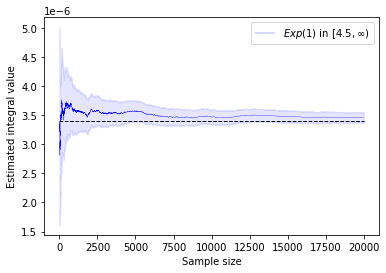

In [39]:
samples = 20000
offset = 50

pdf_exp, _, ppf_exp = truncate(expon.pdf, expon.cdf, expon.ppf, 4.5, np.inf)
g = lambda x: rvs(ppf_exp, x)
d = lambda x: pdf_exp(x)
f_norm = lambda X: norm.pdf(X) * (X >= 4.5)

cum_importance_plot(f_norm, g, d, samples, integrate.quad(f_norm, 4.5, np.inf)[0], 
                    offset, None, True, label = r'$Exp(1)$ in $[4.5, \infty)$', color='b')

Vemos que obtenemos una aproximación bastante buena con 5 veces menos puntos que con la solución 1 (donde directamente no éramos capaces de aproximar el valor de la integral con el tamaño de muestra elegido de 100000 puntos).

## Ejercicio 8

Estimar el valor esperado del segundo momento de la variable aleatoria cuya p.d.f es

$$
f(x)=\frac{1}{2}e^{−|x|}.
$$

utilizando como función de importancia $q(x)$ la densidad de una $\mathcal{N}(0,4)$.

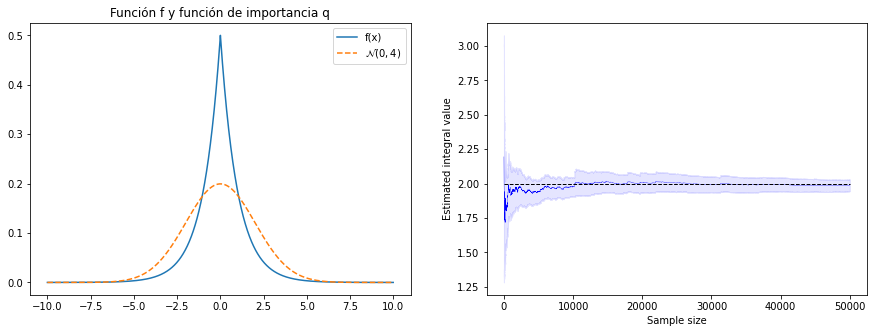

In [40]:
_, axes = plt.subplots(1, 2, figsize=(15,5))

f8 = lambda x: 0.5 * np.exp(-np.abs(x))
x = np.arange(-10, 10, 0.01)
axes[0].set_title("Función f y función de importancia q")
axes[0].plot(x, f8(x), label = "f(x)")
axes[0].plot(x, norm.pdf(x, 0, 2), '--', label=r'$\mathcal{N}(0,4)$')
axes[0].legend()
axes[1].set_title("Repeticiones de los experimentos con aumento paulatino del número de puntos")

samples = 50000
offset = 50

f = lambda x: x**2 * f8(x)
g = lambda x: norm.rvs(0, 2, size=x)
d = lambda x: norm.pdf(x, 0, 2)
cum_importance_plot(f, g, d, samples, 2, offset, axes[1], True, color='b')
plt.show()

Calculando las 100 iteraciones del experimento: [====================] 100%

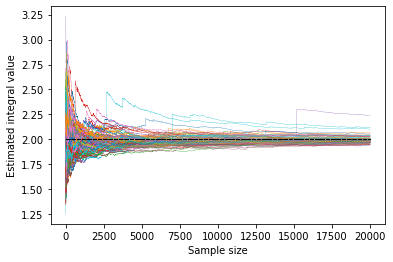

In [41]:
# 100 independent simulations
fig, ax = plt.subplots()
ax.set_title("100 independent simulations")
ax.set_xlabel("Sample size")
ax.set_ylabel("Estimated integral value")

for i in range(100):
    # Display waiting bar
    sys.stdout.write('\r')
    sys.stdout.write("Calculando las 100 iteraciones del experimento: [%-20s] %d%%" % ('='*((i+5)//5), i+1))
    sys.stdout.flush()
    
    cum_importance_plot(f, g, d, 20000, 2, offset, ax=ax, print_ic=False)
plt.show()